In [1]:

#%% Importing modules and data
import smtplib
import pandas as pd
import numpy as np
import datetime as dt
# import pandas.stats.moments as st
import statsmodels.api as sm # import statsmodels 
from pandas import ExcelWriter
import matplotlib.pyplot as pyplot
import scipy.stats as st
import os
import quandl as qd
from collections import defaultdict
import seaborn as sns
%matplotlib inline

def save_xls(list_dfs, xls_path,sheet_names):
    writer = ExcelWriter(xls_path)
    for n, df in enumerate(list_dfs):
        df.to_excel(writer, sheet_names[n])
    writer.save()
    return

C:\Users\scheng\AppData\Local\Continuum\Anaconda3\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
# Importing data from Quandl

btc = qd.get("BITFINEX/BTCUSD", authtoken="-ZxrLoLy3vKgLtLraaMn")
btc.columns = ['High','Low','Mid','Close','Bid','Ask','Volume']

In [3]:
def ichimoku_cloud(df,w9,w26,w52,chikou26):
    #crypto settings are 20, 60, 120, 30 see Josh video for confirmation
    #https://www.youtube.com/watch?v=5x0r-qcGoQQ&t=1s
    
    
    # Tenkan-sen (Conversion Line): (9-period high + 9-period low)/2))
    df['period9_high'] = pd.Series.rolling(df['High'], w9).max()
    df['period9_low'] = pd.Series.rolling(df['Low'], w9).min()
    df['tenkan_sen'] = (df['period9_high'] + df['period9_low']) / 2
    
    # Kijun-sen (Base Line): (26-period high + 26-period low)/2))
    df['period26_high'] = pd.Series.rolling(df['High'], w26).max()
    df['period26_low'] = pd.Series.rolling(df['Low'], w26).min()
    df['kijun_sen'] = (df['period26_high'] + df['period26_low']) / 2
    
    df['period52_high'] = pd.Series.rolling(df['High'], w52).max()
    df['period52_low'] = pd.Series.rolling(df['Low'], w52).min()
    df['senkou_span_b'] = (df['period52_high'] + df['period52_low'] ) /2 
    
    df ['chikou_span'] = df['Close'].shift(chikou26) 
    return df


In [4]:
ichimoku_cloud(btc,20,60,120,30) #crypto settings
#ichimoku_cloud(btc,9,26,52,26) #default settings 
btc = btc.dropna()

In [5]:
btc.iloc[0]

High               492.610000
Low                457.010000
Mid                478.815000
Close              478.200000
Bid                478.390000
Ask                479.240000
Volume           26077.595025
period9_high       605.720000
period9_low        443.000000
tenkan_sen         524.360000
period26_high      665.000000
period26_low       443.000000
kijun_sen          554.000000
period52_high      680.000000
period52_low       419.400000
senkou_span_b      549.700000
chikou_span        616.120000
Name: 2014-08-19 00:00:00, dtype: float64

In [6]:
btc.iloc[1]

High               521.89000
Low                464.00000
Mid                510.74500
Close              510.50000
Bid                510.55000
Ask                510.94000
Volume           29808.26561
period9_high       605.72000
period9_low        443.00000
tenkan_sen         524.36000
period26_high      665.00000
period26_low       443.00000
kijun_sen          554.00000
period52_high      680.00000
period52_low       419.40000
senkou_span_b      549.70000
chikou_span        622.97000
Name: 2014-08-20 00:00:00, dtype: float64

In [7]:
def returns_df(df):
    df['position'] = None
    for row in range(len(df)):
        if df['tenkan_sen'].iloc[row] > df['kijun_sen'].iloc[row]:
            df['position'].iloc[row] = 1
        else:
            df['position'].iloc[row] = -1
    df['position'].fillna(method = 'ffill', inplace = True)
    df['market return'] = np.log(df['Close'] / df['Close'].shift(1))
    df['strategy return'] = df['position'] * df['market return']
    
            
    return df
        

C:\Users\scheng\AppData\Local\Continuum\Anaconda3\lib\site-packages\pandas\core\indexing.py:179: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


,High,Low,Mid,Close,Bid,Ask,Volume,period9_high,period9_low,tenkan_sen,period26_high,period26_low,kijun_sen,period52_high,period52_low,senkou_span_b,chikou_span,position,market return,strategy return
Date,,,,,,,,,,,,,,,,,,,,
2014-08-19,492.61,457.010000,478.815,478.200000,478.39,479.24,26077.595025,605.72,443.00,524.360,665.00,443.0,554.000,680.0,419.4000,549.70000,616.120000,-1,NaN,NaN
2014-08-20,521.89,464.000000,510.745,510.500000,510.55,510.94,29808.265610,605.72,443.00,524.360,665.00,443.0,554.000,680.0,419.4000,549.70000,622.970000,-1,0.065362,-0.065362
2014-08-21,534.89,508.200000,523.140,523.280000,523.00,523.28,17851.968671,605.72,443.00,524.360,665.00,443.0,554.000,680.0,419.4000,549.70000,628.000000,-1,0.024726,-0.024726
2014-08-22,525.00,503.700000,517.905,517.060000,517.81,518.00,12580.632786,605.72,443.00,524.360,665.00,443.0,554.000,680.0,419.4000,549.70000,628.010000,-1,-0.011958,0.011958
2014-08-23,519.20,491.520000,499.115,498.700000,498.80,499.43,9815.395147,605.72,443.00,524.360,665.00,443.0,554.000,680.0,419.4000,549.70000,623.170000,-1,-0.036154,0.036154
2014-08-24,517.70,494.500000,512.580,513.350000,511.81,513.35,5966.563304,605.72,443.00,524.360,665.00,443.0,554.000,680.0,419.4000,549.70000,618.390000,-1,0.028953,-0.028953
2014-08-25,514.30,497.550000,500.295,500.680000,500.00,500.59,7178.063401,598.88,443.00,520.940,665.00,443.0,554.000,680.0,419.4000,549.70000,620.300000,-1,-0.024991,0.024991
2014-08-26,517.47,497.750000,506.805,506.500000,506.50,507.11,10882.904136,598.88,443.00,520.940,665.00,443.0,554.000,680.0,419.4000,549.70000,618.900000,-1,0.011557,-0.011557
2014-08-27,522.80,506.500000,510.975,511.150000,510.76,511.19,7472.539320,598.88,443.00,520.940,665.00,443.0,554.000,680.0,419.4000,549.70000,601.000000,-1,0.009139,-0.009139


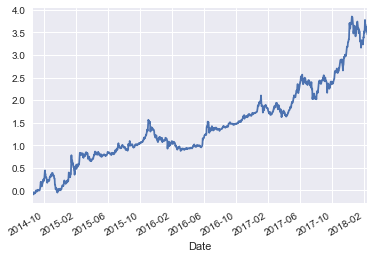

In [8]:
returns_df(btc)

In [9]:
def risk_measures(df):
    pass

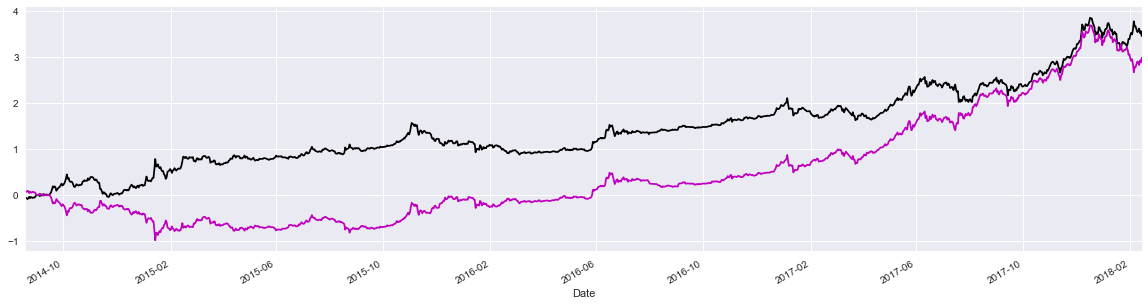

In [12]:
btc['strategy return'].cumsum().plot(grid = True, figsize = (20,5), color = 'k')
btc['market return'].cumsum().plot(grid = True, figsize = (20,5), color = 'm')

In [14]:
btc['strategy return'].cumsum().tail(5)

Date
2018-02-10    3.558122
2018-02-11    3.618255
2018-02-12    3.521886
2018-02-13    3.561968
2018-02-14    3.458261
Name: strategy return, dtype: float64

In [15]:
btc['market return'].cumsum().tail(5)

Date
2018-02-10    2.885889
2018-02-11    2.825756
2018-02-12    2.922124
2018-02-13    2.882042
2018-02-14    2.985750
Name: market return, dtype: float64